In [ ]:
# Randomly sample files to read
import random
from pathlib import Path

in_dir = Path("data/librispeech-wav")
sample_size = 20

wav_paths = list(in_dir.rglob("*.wav"))
# wav_paths = [
#     Path("data/librispeech-wav/174-50561-0005.wav"),
#     Path("data/librispeech-wav/174-50561-0013.wav"),
#     Path("data/librispeech-wav/3081-166546-0003.wav"),
#              ]
wav_paths = [Path("data/librispeech-wav/2428-83699-0006.wav")]

if sample_size < len(wav_paths):
    sampled_paths = random.sample(wav_paths, sample_size)
else:
    sampled_paths = wav_paths  

print(len(sampled_paths))

3


In [208]:
# Get true word dict
def parse_text_to_dict(file):
    with open(file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    data_dict = {}
    current_id = None
    word_dict = {}

    for line in lines: 
        line = line.strip()

        if not line: 
            continue
        
        if line.endswith(":") and not line.split(":")[0].isdigit():
            if current_id is not None:
                data_dict[current_id] = word_dict
            
            current_id = line[:-1]
            word_dict = {}
        else:
            parts = line.split(": ")
            if len(parts) == 2:
                index, word = parts
                word_dict[int(index)] = word.strip()
            else:
                parts = parts[0].split(":")
                index = parts[0]
                word_dict[int(index)] = " "
            
            if current_id is not None:
                data_dict[current_id] = word_dict
        
    return data_dict

true_words_dict = parse_text_to_dict("data/words_and_indices.txt")

In [333]:
from torchaudio.functional import resample
import torch
import torchaudio
from tqdm import tqdm
from webrtcvad import Vad
import struct
import numpy as np
import torch.nn.functional as F


INT16_MAX = (2**15) - 1
hop_length = 320
sample_rate = 16000

def mark_sil(vad, wav):
    wav = F.pad(wav, (40, 40))  # add padding to match HuBERT
    wav = wav[:, : wav.size(-1) - (wav.size(-1) % hop_length)]

    pcm = struct.pack(
        "%dh" % wav.size(-1),
        *(np.round(wav.squeeze().numpy() * INT16_MAX)).astype(np.int16),
    )

    flags = []
    for window_start in range(0, wav.size(-1), hop_length):
        window_end = window_start + hop_length
        flag = vad.is_speech(pcm[window_start * 2 : window_end * 2], sample_rate)
        flags.append(flag)
    return flags


hubert = torch.hub.load(
    "bshall/hubert:main",
    "hubert_discrete",
    trust_repo=True,
)
vad = Vad()

acoustic_units = {}
flags = {}
for wav_path in tqdm(sampled_paths, desc="Getting HuBERT units"):
    wav, sr = torchaudio.load(wav_path)
    wav = resample(wav, sr, 16000)
    
    flag = mark_sil(vad, wav)
    wav = wav.unsqueeze(0)

    with torch.inference_mode():
        units = hubert.units(wav)
    acoustic_units[wav_path.stem] = units.numpy()
    flags[wav_path.stem] = flag


Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting HuBERT units: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


In [336]:
for path in acoustic_units:
    
    if len(acoustic_units[path]) < len(flags[path]):
        flags[path] = flags[path][0:len(acoustic_units[path])]
    
    print(len(acoustic_units[path]))
    print(len(flags[path]))

285
285
530
530
206
206


In [215]:
import numpy as np

layer = 7
hubert, encode = torch.hub.load(
    "bshall/dusted:main", "hubert", language="english", trust_repo=True
)

encodings = {}
for wav_path in tqdm(sampled_paths, desc="Encoding Audio Features"):
    wav, sr = torchaudio.load(wav_path)
    wav = resample(wav, sr, 16000)
    wav = wav.unsqueeze(0)
    x = encode(hubert, wav, layer)
    encodings[wav_path.stem] = x.squeeze(0)


Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Encoding Audio Features: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


In [211]:
print(true_words_dict)

{'2428-83699-0032': {0: 'maybe', 1: "they're", 2: 'up', 3: 'to', 4: 'some', 5: 'of', 6: 'their', 7: 'games', 8: 'and', 9: 'wants', 10: 'rousing', 11: ' '}, '2428-83699-0002': {0: 'the', 1: 'reply', 2: 'was', 3: 'written', 4: 'in', 5: 'a', 6: 'sprawling', 7: 'feminine', 8: 'hand', 9: ' ', 10: 'it', 11: 'was', 12: 'a', 13: 'little', 14: 'vague', 15: ' '}, '2428-83699-0030': {0: 'no', 1: 'answer', 2: 'though', 3: ' ', 4: 'i', 5: 'allowed', 6: 'a', 7: 'more', 8: 'than', 9: 'decent', 10: 'interval', 11: ' '}, '2428-83699-0025': {0: 'i', 1: 'had', 2: 'long', 3: 'been', 4: 'wishing', 5: 'that', 6: 'an', 7: 'old', 8: 'fashioned', 9: 'christmas', 10: ' ', 11: 'had', 12: 'been', 13: 'completely', 14: 'extinct', 15: ' ', 16: 'before', 17: 'i', 18: 'had', 19: 'thought', 20: 'of', 21: 'adventuring', 22: 'in', 23: 'quest', 24: 'of', 25: 'one', 26: ' '}, '2428-83699-0006': {0: 'now', 1: 'it', 2: 'is', 3: 'a', 4: 'remarkable', 5: 'thing', 6: 'that', 7: 'i', 8: 'have', 9: 'always', 10: 'had', 11: 'an',

In [216]:
align_dir = Path("data/all_alignments")
align_paths = list(align_dir.rglob("*.list"))

def get_frame_num(timestamp, sample_rate, frame_size_ms):
    hop = frame_size_ms/1000 * sample_rate
    hop_size = np.max([hop, 1])
    return int((timestamp * sample_rate) / hop_size)

filenames = {}
cut_encodings = {}
index = 1
for path in tqdm(encodings, desc="Cutting Encodings"):
    alignment_file = [a for a in align_paths if a.stem == path]
    if not alignment_file:
        continue
    else:
        alignment_file = alignment_file[0]

    with open(str(alignment_file), "r") as f:
        bounds = [get_frame_num(float(line.strip()), 16000, 20) for line in f]
    
    cuttings = {}
    cut_x = encodings[path][0:bounds[0],]
    cuttings[''] = cut_x
    
    for i in range(len(bounds)-1): 
        cut_x = encodings[path][bounds[i]:bounds[i+1],]
        cuttings[true_words_dict[path][i]] = cut_x
        filenames[index] = f"{path}_{i+1}"
        index += 1
    cut_encodings[path] = cuttings

Cutting Encodings: 100%|██████████| 3/3 [00:00<00:00, 616.72it/s]


In [217]:
for path in cut_encodings:
    for word in cut_encodings[path]:
        print(f"'{word}'")
        print(cut_encodings[path][word])
        break
    break

''
tensor([[-0.0548, -0.0792,  0.0072,  ..., -0.1810,  0.1244, -0.0972],
        [-0.0378, -0.0697,  0.0049,  ..., -0.1701,  0.1358, -0.0442],
        [-0.0204, -0.0779, -0.0437,  ..., -0.1854,  0.1053, -0.1062],
        ...,
        [ 0.3021,  0.3263, -0.2211,  ..., -0.2472, -0.2507, -0.4687],
        [ 0.1833,  0.3322, -0.2553,  ..., -0.2216, -0.0828, -0.1099],
        [ 0.3214,  0.2667, -0.3332,  ..., -0.3143, -0.2860, -0.1940]])


In [218]:
kmeans, segment = torch.hub.load(
    "bshall/dusted:main", "kmeans", language="english", trust_repo=True
)

gamma = 0.001

dusted_units = {}
for path in cut_encodings:
    words = {}
    for word in cut_encodings[path]:
        sequence = cut_encodings[path][word]
        codes, boundaries = segment(sequence, kmeans.cluster_centers_, gamma)
        words[word] = codes
    dusted_units[path] = words


Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main


In [219]:
for path in cut_encodings:
    print(path)
    for word in cut_encodings[path]:
        print(f"'{word}':{dusted_units[path][word]}")
        break
    break

174-50561-0005
'':[ 6 69 74 69 74 69 74 19]


In [339]:
import numpy as np 

align_dir = Path("data/all_alignments")
align_paths = list(align_dir.rglob("*.list"))

def get_frame_num(timestamp, sample_rate, frame_size_ms):
    hop = frame_size_ms/1000 * sample_rate
    hop_size = np.max([hop, 1])
    return int((timestamp * sample_rate) / hop_size)

filenames = {}
cut_flags = {}
cut_units = {}
index = 1
for path in tqdm(acoustic_units, desc="Cutting Acoustic Unit Sequences"):
    alignment_file = [a for a in align_paths if a.stem == path]
    if not alignment_file:
        continue
    else:
        alignment_file = alignment_file[0]

    with open(str(alignment_file), "r") as f:
        bounds = [get_frame_num(float(line.strip()), 16000, 20) for line in f]
    
    # Dict per path for the words (and their units) in that path
    cuttings = {}
    cut_unit = acoustic_units[path][0:bounds[0]]
    cuttings[0] = ' ', cut_unit

    # Array per path for the flags of the words in that path 
    flag_cuttings = []
    cut_flag = flags[path][0:bounds[0]]
    flag_cuttings.append(cut_flag)

    filenames[0] = f"{path}_{0}"
    for i in range(1, len(bounds)): 
        cut_unit = acoustic_units[path][bounds[i-1]:bounds[i]]
        cuttings[i] = true_words_dict[path][i-1], cut_unit

        cut_flag = flags[path][bounds[i-1]:bounds[i]]
        flag_cuttings.append(cut_flag)

        filenames[index] = f"{path}_{i}"
        index += 1

    cut_flags[path] = flag_cuttings
    cut_units[path] = cuttings


Cutting Acoustic Unit Sequences: 100%|██████████| 3/3 [00:00<00:00, 831.05it/s]


In [ ]:
vad_cut_units = {}
for path in cut_units:
    print(path)
    for word in (cut_units[path]):
        print(f"'{cut_units[path][word][0]}': {cut_units[path][word][1]}")
        print(cut_flags[path][word])

        vad_word = []

        print(len(cut_units[path][word][1]), len(cut_flags[path][word]))
        for j in range(len(cut_flags[path][i])):
            if cut_flags[path][i][j]:
                vad_word.append(cut_units[path][word][1][j])
                
        print(vad_word)
        
    break

174-50561-0005
' ': [ 6  6  6  6  6  6 69 69 74 69 69 69 69 69 74 69 69 69 69 69 74 19 19 19
 19]
[True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
25 25
[np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(6), np.int64(69), np.int64(69), np.int64(74), np.int64(69), np.int64(69), np.int64(69), np.int64(69), np.int64(69), np.int64(74), np.int64(69), np.int64(69), np.int64(69), np.int64(69), np.int64(69), np.int64(74)]
'lady': [74 90 90 17 17 17 17 17 95 48 48 48 48 48 20 20 12 82 55 40 57 57 57 91
 91 91 91 16]
[False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
28 28
[np.int64(74), np.int64(90), np.int64(90), np.int64(17), np.int64(17), np.int64(17), np.int64(17), np.int64(17), np.int64(95), np.int64(48), np.int64(48), np.int64(4

IndexError: index 3 is out of bounds for axis 0 with size 3

In [186]:
for path in cut_units:
    print(path)
    for word in cut_units[path]:
        print(word)
        print()
        break
    break
    

3000-15664-0017




In [187]:
just_words = []

index = 0
for path in cut_units:
    for i in range(len(cut_units[path])):
        just_words.append(cut_units[path][i])

num_words = len(just_words)
print(num_words)

KeyError: 0

In [221]:
no_filenames_a = {}
no_filenames_d = {}
for path in cut_units:
    for word in cut_units[path]:
        no_filenames_a[word] = cut_units[path][word]
        no_filenames_d[word] = dusted_units[path][word]

In [190]:
from joblib import Parallel, delayed

def edit_distance(seq1, seq2):
    """
    Compute the edit distance between two sequences using dynamic programming.
    """
    N, M = len(seq1), len(seq2)
    dp = np.zeros((N + 1, M + 1))
    for i in range(N + 1):
        dp[i, 0] = i
    for j in range(M + 1):
        dp[0, j] = j
    for i in range(1, N + 1):
        for j in range(1, M + 1):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1
            dp[i, j] = min(dp[i - 1, j] + 1, dp[i, j - 1] + 1, dp[i - 1, j - 1] + cost)
    return dp[N, M] 

def calculate_distance(just_words, num_words):
    dist_mat = np.zeros((num_words, num_words))

    for i in tqdm(range(num_words), desc="Calculating Distances"):
        js = [j for j in range(i + 1, num_words)]
        dists_i = Parallel(n_jobs=8)(
            delayed(edit_distance)(just_words[i], just_words[j]) for j in js
        )

        for j, dist in zip(js, dists_i):
            dist_mat[i, j] = dist
            dist_mat[j, i] = dist  
    
    return dist_mat

In [191]:
dist_mat = calculate_distance(just_words, num_words)
print(dist_mat[0:5, 0:5])

Calculating Distances:   0%|          | 0/39 [00:00<?, ?it/s]


IndexError: list index out of range

In [192]:

import editdistance
import numpy as np

dist_mat = np.zeros((num_words, num_words))

for u in range(num_words):
    for v in range(u + 1, num_words):
        dist_mat[u, v] = editdistance.eval(just_words[u], just_words[v])

print(dist_mat[0:5, 0:5])

IndexError: list index out of range

In [222]:
import numpy as np
import pandas as pd
from itertools import combinations
from nltk.metrics import edit_distance
import seaborn as sns
import matplotlib.pyplot as plt

names = list(no_filenames_a.keys())
n = len(names)
dist_matrix = np.zeros((n, n))

for i, j in combinations(range(n), 2):
    name_i, name_j = names[i], names[j]
    a_i = no_filenames_a[name_i]
    a_j = no_filenames_a[name_j]
    d_i = no_filenames_d[name_i]
    d_j = no_filenames_d[name_j]

    dist_mat_a = edit_distance(a_i, a_j)
    dist_mat_d = edit_distance(d_i, d_j)
    
    avg_dist = (dist_mat_a + dist_mat_d)/2
    dist_matrix[i,j] = avg_dist
    dist_matrix[j,i] = avg_dist


In [223]:
from scipy.cluster.hierarchy import linkage, leaves_list

dist_df = pd.DataFrame(dist_matrix, index=names, columns=names)

linked = linkage(dist_matrix, method='average')

order = leaves_list(linked)
reordered_dist_df = dist_df.iloc[order, order]

/tmp/ipykernel_4108/2850518890.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist_matrix, method='average')


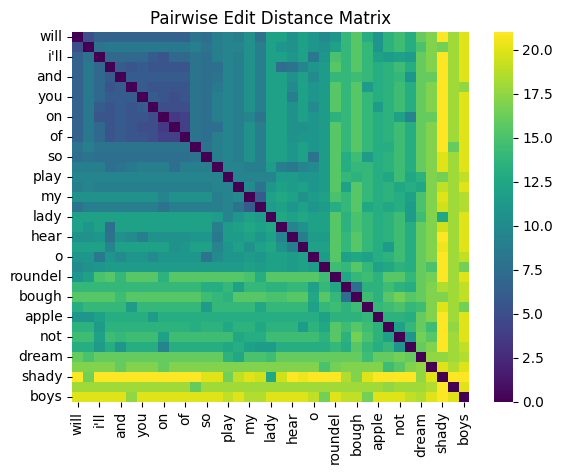

In [224]:
plt.Figure(figsize=(8,6))
sns.heatmap(reordered_dist_df, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()

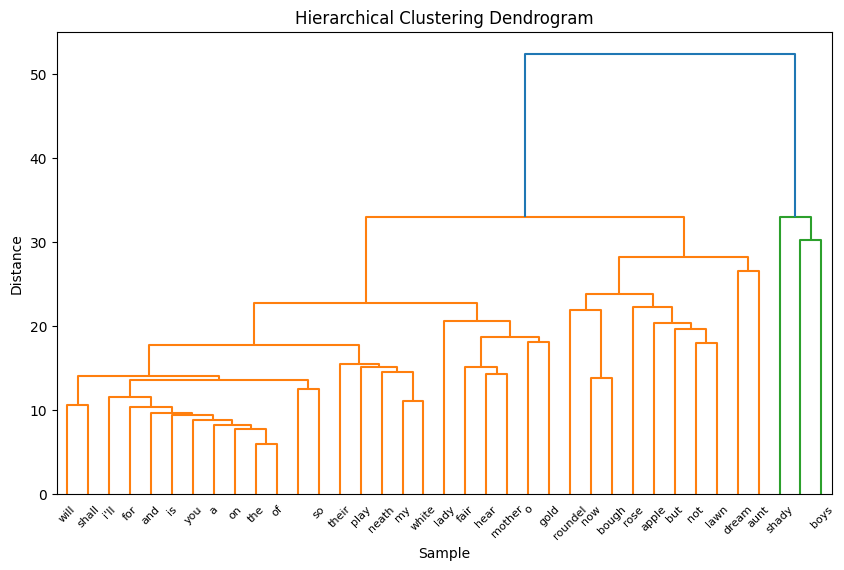

In [225]:
from scipy.cluster.hierarchy import dendrogram

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=names)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()

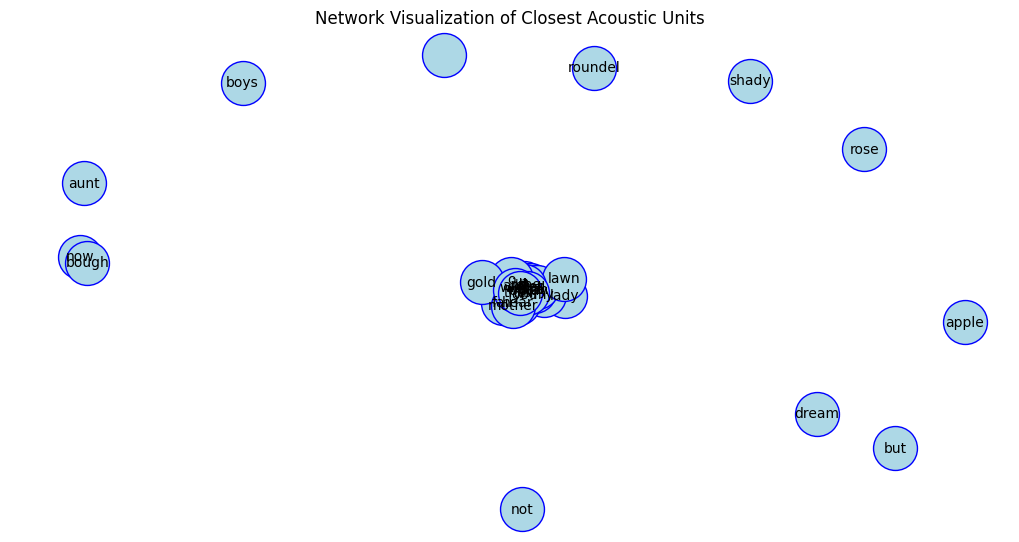

In [243]:
import networkx as nx

# Define threshold for close similarity
threshold = 10  # Adjust this threshold as needed

# Create a graph
G = nx.Graph()

# Add edges for pairs closer than the threshold
for i, j in combinations(range(n), 2):
    G.add_node(names[i])
    G.add_node(names[j])
    if dist_matrix[i, j] <= threshold:
        
        G.add_edge(names[i], names[j], weight=dist_matrix[i, j])

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # Positions nodes using spring layout
edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(10,5))
nx.draw(G,pos,node_color='lightblue',node_size=1000, edgecolors='blue', with_labels=True, font_size=10)
nx.draw_networkx_edges(G, pos, edge_color='blue')
plt.title('Network Visualization of Closest Acoustic Units')
plt.show()


In [232]:
# Clustering algorithm 
def cluster(dist_mat, distance_threshold):
    num_nodes = dist_mat.shape[0]
    graph = {i: set() for i in range(num_nodes)}

    for i in range(num_nodes - 1): 
        for j in range(i + 1, num_nodes):  
            if dist_mat[i, j] < distance_threshold:
                graph[i].add(j)
                graph[j].add(i)  


    clusters = []
    visited = set()

    def bfs(start_node):
        """ Traverse a cluster using BFS """
        queue = [start_node]
        cluster = []
        
        while queue:
            node = queue.pop(0)
            if node in visited:
                continue 
            visited.add(node)
            cluster.append(node)
            queue.extend(graph[node])  

        return cluster

    for node in range(num_nodes):
        if node not in visited:
            new_cluster = bfs(node)
            clusters.append(new_cluster)

    return clusters

In [233]:
au_clusters = cluster(dist_mat, 20)
print(len(au_clusters))

1


In [234]:
# Cluster and WordUnit classes
from collections import defaultdict

class Cluster:
    def __init__(self,id, word_dict=None, true_words=None):
        self.id = id
        self.length = len(word_dict) if word_dict else 0
        self.word_dict = word_dict if word_dict is not None else []
        self.true_word_dict = true_words if true_words is not None else []
    
    def add_word_unit(self, id, index, file):
        word_unit = WordUnit(file, index, id)
        self.length += 1
        self.word_dict.append(word_unit)

    def add_true_word(self, word):
        self.true_word_dict.append(word)

    @classmethod
    def print_cluster(self, cluster):
        print(f"Cluster {cluster.id}")
        for word in cluster.word_dict:
            print(f"Word {word.id}: Index {word.index} in File {word.file}")
    
    def cluster_purity(self):

        word_counts = {}
        for word in self.true_word_dict:
            word_counts[word] = word_counts.get(word, 0) + 1

        max_count = max(word_counts.values()) if word_counts else 0
        cluster_purity = max_count / self.length if self.length > 0 else 0

        self.purity = cluster_purity

    @classmethod
    def duplicate_clusters(self, clusters):
        cluster_dict = defaultdict(int)

        for cluster in clusters:
            cluster_set = frozenset(cluster)  
            cluster_dict[cluster_set] += 1  

        duplicate_count = sum(1 for count in cluster_dict.values() if count > 1)

        return duplicate_count

class WordUnit:
    def __init__(self, file, index, id):
        self.index = int(index)
        self.file = file
        self.id = int(id)
        self.start_time = None
        self.end_time = None

    def add_word_boundaries(self, start_time, end_time):
        self.start_time = start_time
        self.end_time = end_time
    

In [238]:
au_clusters = cluster(dist_mat, 2)
clusters = []
for i, c in enumerate(au_clusters):
    new_c = Cluster(i)
    for w in range(len(c)):
        if c[w] in filenames:
            filename_parts = filenames[c[w]].split("_")
            filename = filename_parts[0]
            word_index = int(filename_parts[1])        
            new_c.add_word_unit(w, word_index, filename)
    clusters.append(new_c)

for c in clusters:
    # print(c.id)
    for word_unit in c.word_dict:
        # if len(c.word_dict) > 1:
        #     print(word_unit.file, word_unit.index)
        if word_unit.index == 0:
            word = ''
        else:
            word = true_words_dict[word_unit.file][word_unit.index-1]
        
        c.add_true_word(word)
    print()
    
    if len(c.word_dict) > 0:  
        print(f"Cluster {c.id}: ", end="")                
        print(", ".join(c.true_word_dict))
        print()



Cluster 0: , lady,  , lady,  , my, rose, white, lady,  , but, will, you, not, hear, a, roundel, lady,  , i'll, play, for, you, now,  , neath, the, apple, bough,  , and, you, shall, dream, on,  , the, lawn, so

